In [1]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import zarr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import PIL
import imageio
import shapely

# load the configuration file
from l5kit.configs import load_config_data
from l5kit.configs.config import load_metadata
# load the dataset from zarr
from l5kit.data import ChunkedDataset, LocalDataManager
# load the Ego/Agent-based dataset
from l5kit.dataset import EgoDataset, AgentDataset, IntersectionDataset
# define the road_network protobuf data structure
from l5kit.data.proto.road_network_pb2 import RoadNetworkNode, RoadNetworkSegment
# Semantic map api
from l5kit.data.map_api import MapAPI
# rasterizer
from l5kit.rasterization import build_rasterizer
# geometry
from l5kit.geometry import transform_points
# trajectory
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
# get Agents info
from l5kit.sampling.agent_sampling import get_agent_context

D:\github\lyft_intersection\l5kit\l5kit\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


## Extract index

In [2]:
# load the configuration file
cfg = load_config_data("./yaml_config/visualisation_config_sample.yaml")
print(cfg)

# load the dataset from zarr
os.environ["L5KIT_DATA_FOLDER"] = "./" ## Set the environmental variable
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
# print(dataset_path) # scenes\sample.zarr
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_num_frames_ego': 0, 'history_num_frames_agents': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.9, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes-sample/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene

In [3]:
# create the rasterizer and dataset

cfg["raster_params"]["map_type"] = "intersection" # "py_satellite" # "py_semantic"   
intersection_rast = build_rasterizer(cfg, dm)
intersection_dataset = IntersectionDataset(cfg, zarr_dataset, intersection_rast)

In [4]:
print(f"#frames in the {cfg['val_data_loader']['key']}: {len(intersection_dataset)}")
print(f"#scenes in the {cfg['val_data_loader']['key']}: {len(intersection_dataset.cumulative_sizes)}")

#frames in the scenes-sample/sample.zarr: 24838
#scenes in the scenes-sample/sample.zarr: 100


```python
# keys in a frame:

dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 
        'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 
        'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 
        'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'scene_index', 
        'host_id', 'timestamp', 'track_id', 'is_intersection_included'])
```

Iterate the dataset to get all the frames that include the intersection

In [5]:
frames_including_intersection = []
scenes_including_intersection = []

for idx, frame in tqdm(enumerate(intersection_dataset), 
                       total=len(intersection_dataset), 
                       unit="frame",
                       desc=f"Identify the intersection of interest inside {cfg['val_data_loader']['key']}:"):
    if frame["is_intersection_included"]:
        # save the frame_id
        frames_including_intersection.append(idx)
        # FIXME: save the scene_id
        scenes_including_intersection.append(frame["scene_index"])

Identify the intersection of interest inside scenes-sample/sample.zarr::   0%|          | 0/24838 [00:00<?, ?f…

In [6]:
len(set(frames_including_intersection)), len(set(scenes_including_intersection))

(1950, 11)

In [7]:
print(f"#scenes including the intersection:\n{set(scenes_including_intersection)}")

#scenes including the intersection:
{7, 8, 42, 43, 76, 77, 56, 57, 91, 92, 93}


In [8]:
import pickle

# TODO: save the ids in picked files:
with open("./pickle_backup/sample_scenes_including_intersection.pkl", 'wb') as file:
    pickle.dump(set(scenes_including_intersection), file)

with open("./pickle_backup/sample_frames_including_intersection.pkl", 'wb') as file:
    pickle.dump(set(frames_including_intersection), file)

## Visualization / Verification

Use GIF animation to check whether the frame includes the intersection

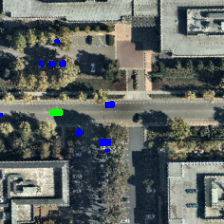

In [8]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 43
indexes = dataset.get_scene_indices(scene_idx)
images = [] # to store the frame for GIF

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    # draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
    clear_output(wait=True)
    display(PIL.Image.fromarray(im))

    pil_image = PIL.Image.fromarray(im)
    images.append(pil_image)

imageio.mimsave(f"./scene_gif/scene_{scene_idx}.gif", images)
clear_output(wait=True)

Use satellite map to check whether the frame includes the intersection

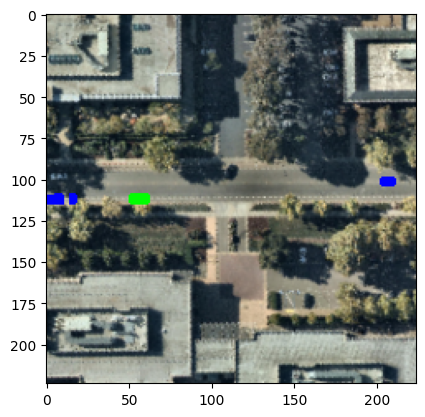

In [9]:
frameIndex = 1809
cfg["raster_params"]["map_type"] = "py_satellite" # "intersection" # "py_semantic"   
rast = build_rasterizer(cfg, dm)
dataset = IntersectionDataset(cfg, zarr_dataset, rast)
data = dataset[frameIndex]

im = data["image"].transpose(1, 2, 0) # (224, 224, 5)
im = dataset.rasterizer.to_rgb(im) # (224, 224, 3)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
# draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

## Transform the trajectories

In [10]:
intersection_dataset[1808].keys()

dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'is_intersection_included', 'agents_centroid', 'scene_index', 'host_id', 'timestamp', 'track_id'])

In [11]:
set(scenes_including_intersection)

{7, 8, 42, 43, 56, 57, 76, 77, 91, 92, 93}

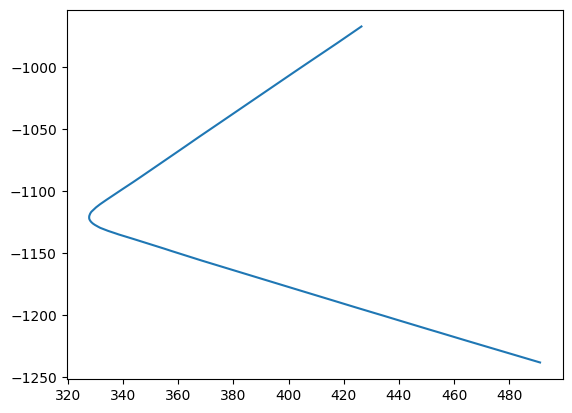

In [12]:
# scene: 7,8

trajectory = np.zeros((1,2))
frame_list = intersection_dataset.get_scene_indices(scene_idx=7).tolist() + intersection_dataset.get_scene_indices(scene_idx=8).tolist()
for frame_index in frame_list:
    centroid = intersection_dataset[frame_index]["centroid"].reshape((1,2))
    trajectory = np.append(arr=trajectory, values=centroid, axis=0)

trajectory = trajectory[1:,:]
plt.plot(trajectory[:,0], trajectory[:,1]) 

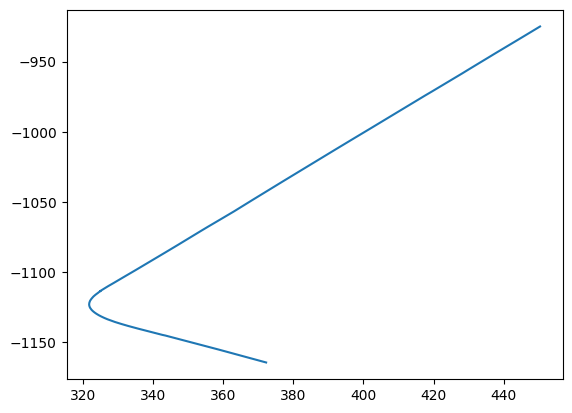

In [13]:
# scene: 42,43

trajectory = np.zeros((1,2))
frame_list = intersection_dataset.get_scene_indices(scene_idx=42).tolist() + intersection_dataset.get_scene_indices(scene_idx=43).tolist()
for frame_index in frame_list:
    centroid = intersection_dataset[frame_index]["centroid"].reshape((1,2))
    trajectory = np.append(arr=trajectory, values=centroid, axis=0)

trajectory = trajectory[1:,:]
plt.plot(trajectory[:,0], trajectory[:,1]) 

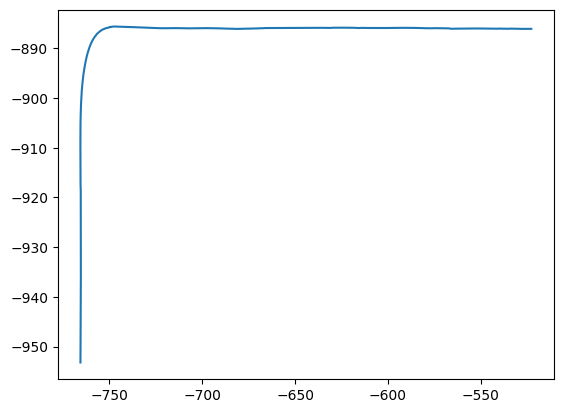

In [14]:
theta = 56.5
rotation_matrix = np.array([
    [np.cos(np.deg2rad(theta)), np.sin(np.deg2rad(theta))], 
    [-1*np.sin(np.deg2rad(theta)), np.cos(np.deg2rad(theta))]
])
rotation_matrix

transformed_trajectory = np.matmul(rotation_matrix, trajectory.T)
plt.plot(transformed_trajectory[0,:], transformed_trajectory[1,:]) 

In [15]:
from shapely.geometry import LineString, Point

trajectory = LineString(coordinates=transformed_trajectory.T)
trajectory_buffer = trajectory.buffer(1, single_sided=False)



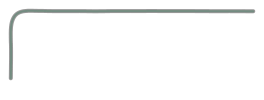

In [16]:
trajectory_buffer # trajectory

In [17]:
line = LineString([(0, 0), (1, 1)])
line.intersects(LineString([(1, 0), (0, 1)]))

True

In [18]:
line.intersection(LineString([(1, 0), (0, 1)])).xy

(array('d', [0.5]), array('d', [0.5]))

In [19]:
dataset = AgentDataset(cfg, zarr_dataset, rast)


D:\github\lyft_intersection\l5kit\l5kit\l5kit\dataset\agent.py:32: RuntimeWarning: cannot find the right config in scenes-sample\sample.zarr,
your cfg has loaded filter_agents_threshold=0.9;
but that value doesn't have a match among the agents_mask in the zarr
Mask will now be generated for that parameter.
  agents_mask = self.load_agents_mask()


starting pool...


100/100: : 100it [00:13,  7.16it/s]


collecting results..
start report for scenes-sample\sample.zarr
{   'reject_th_AV_distance': 204220,
    'reject_th_agent_filter_probability_threshold': 1324481,
    'reject_th_extent': 84257,
    'reject_th_yaw': 5178,
    'th_agent_filter_probability_threshold': 0.9,
    'th_distance_av': 50,
    'th_extent_ratio': 1.1,
    'th_yaw_degree': 30,
    'total_agent_frames': 1893736,
    'total_reject': 1618136}


computing past/future table: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.78it/s]

+-------------+---------+--------+-------+-------+
| past/future |    0    |   10   |   30  |   50  |
+-------------+---------+--------+-------+-------+
|      0      | 1893736 | 116054 | 64972 | 42984 |
|      10     |  116054 | 83760  | 52277 | 36140 |
|      30     |  64972  | 52277  | 36140 | 26364 |
|      50     |  42984  | 36140  | 26364 | 19560 |
+-------------+---------+--------+-------+-------+
end report for scenes-sample\sample.zarr


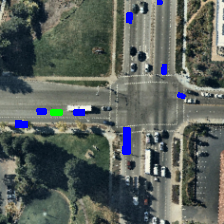

In [20]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 3
indexes = dataset.get_scene_indices(scene_idx)
images = [] # to store the frame for GIF

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    # draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
    clear_output(wait=True)
    display(PIL.Image.fromarray(im))

    pil_image = PIL.Image.fromarray(im)
    images.append(pil_image)

# imageio.mimsave(f"./scene_gif/scene_{scene_idx}.gif", images)
# clear_output(wait=True)

In [21]:
get_agent_context?

Signature:
get_agent_context(
    state_index: int,
    frames: numpy.ndarray,
    agents: numpy.ndarray,
    tl_faces: numpy.ndarray,
    history_num_frames: int,
    future_num_frames: int,
) -> Tuple[numpy.ndarray, numpy.ndarray, List[numpy.ndarray], List[numpy.ndarray], List[numpy.ndarray], List[numpy.ndarray]]
Docstring:
Slice zarr or numpy arrays to get the context around the agent onf interest (both in space and time)

Args:
    state_index (int): frame index inside the scene
    frames (np.ndarray): frames from the scene
    agents (np.ndarray): agents from the scene
    tl_faces (np.ndarray): tl_faces from the scene
    history_num_frames (int): how many frames in the past to slice
    future_num_frames (int): how many frames in the future to slice

Returns:
    Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]
File:      d:\github\lyft_intersection\l5kit\l5kit\l5kit\sampling\agent_sampling.py
Type:      function

In [22]:
get_agent_context()

TypeError: get_agent_context() missing 6 required positional arguments: 'state_index', 'frames', 'agents', 'tl_faces', 'history_num_frames', and 'future_num_frames'